In [3]:
import collections

import pyDNase
import tensorflow as tf
import h5py
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import kipoi
import os
import pybedtools
import torch
import h5sparse
import datetime
import logging

from pyDNase import GenomicInterval
from scipy.sparse import coo_matrix, vstack

from scipy.fftpack import fft, ifft

import sys

# Define Paths for this user

In [4]:
########################## PATHS ###########################
# path to where dnase bams are stored. Bams need to be sorted and indexed. See bin/download_dnase_encode.sh for
# data processing
_ENCODE_DATA_PREFIX =  "/data/akmorrow/encode_data/"

deepsea_path = "/data/akmorrow/epitome_data/deepsea_train/"
dnase_preprocessed_path = "/data/akmorrow/epitome_data/processed_dnase/"
feature_path = "/home/eecs/akmorrow/epitome/data/feature_name"

_DEEPSEA_GENOME_REGIONS_FILENAME = "/home/eecs/akmorrow/epitome/data/allTFs.pos.bed"

# DNase filepath dictionary
prefix_ =  "/data/akmorrow/encode_data/"


# get TF logger
log = logging.getLogger('tensorflow')
tf_log = "/home/eecs/akmorrow/epitome/dnase/tensorflow_combination.log"
fh = logging.FileHandler(tf_log)
fh.setLevel(logging.INFO)
log.addHandler(fh)

In [5]:
exec(open("./constants.py").read())
exec(open("./functions.py").read())

# Load Data

### Load DeepSEA data

In [4]:
train_data, valid_data, test_data = load_deepsea_data(deepsea_path)

print(valid_data["x"].shape, train_data["x"].shape, test_data["x"].shape)
print(valid_data["y"].shape, train_data["y"].shape, test_data["y"].shape)

(408000, 4, 1000) (4000000, 4, 1000) (455024, 4, 1000)
(919, 408000) (919, 4000000) (919, 455024)


### Load Cut Sites

In [5]:
### Load DNase data to h5sparse files
dnase_train = h5sparse.File(0(dnase_preprocessed_path, "processed_dnase_train_sparse.h5"))
dnase_valid = h5sparse.File(os.path.join(dnase_preprocessed_path, "processed_dnase_valid_sparse.h5"))
dnase_test  = h5sparse.File(os.path.join(dnase_preprocessed_path, "processed_dnase_test_sparse.h5"))

In [52]:
%%time
# This code moves around the results in validation and test so that the validation set is larger
dnase_valid_dict = toSparseIndexedDictionary(dnase_train, dnase_valid,dnase_test, Dataset.VALID, normalize = True)
dnase_test_dict = toSparseIndexedDictionary(dnase_train, dnase_valid,dnase_test, Dataset.TEST, normalize = True)
dnase_train_dict = toSparseIndexedDictionary(dnase_train, dnase_valid,dnase_test, Dataset.TRAIN, normalize = True)


CPU times: user 46.6 s, sys: 33.2 s, total: 1min 19s
Wall time: 1min 19s


# Choose cell types

['K562', 'GM12878', 'H1-hESC', 'HepG2', 'HeLa-S3', 'A549', 'HUVEC', 'GM12891', 'MCF-7', 'GM12892', 'HCT-116'] ['DNase', 'CTCF', 'Pol2', 'YY1', 'p300', 'TAF1', 'Pol2-4H8', 'c-Myc', 'Rad21', 'Max', 'NRSF', 'GABP', 'EZH2', 'CEBPB', 'c-Jun', 'ZBTB33', 'USF2', 'USF-1', 'TBP', 'RFX5']


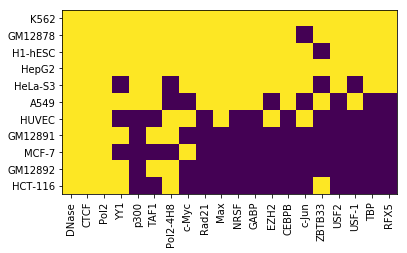

In [6]:
# matrix is cell types by factors, contains indices in feature vector
matrix, cellmap, assaymap = get_assays_from_feature_file()

inv_assaymap = {v: k for k, v in assaymap.items()}

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.xticks(np.arange(len(assaymap)), rotation = 90)
ax.set_xticklabels(assaymap.keys())
plt.yticks(np.arange(len(cellmap)))
ax.set_yticklabels(cellmap.keys())

plt.imshow(matrix!=-1)
print(list(cellmap.keys())[:11], list(assaymap.keys())[:20])

# Select train, valid and test cell types

- test on A549
- train/validate on K562 and HepG2
- use remaining cell types as feature input 

In [54]:
# A549 is for test. 12 available features
test_celltypes = ["A549"]

valid_y_indices = np.copy(matrix[cellmap['A549']])
# indices that are unavailable for A549
valid_holdout_indices = np.where(valid_y_indices == -1)[0]
# TODO: need the vectors to be the same length, but you should not evaluate on these
# Currently, set -1's to 0 these will all be evaluated on the DNase
valid_y_indices[matrix[cellmap['A549']] ==-1]=0

# K562, HepG2 indices is for train/valid. 19 available features
evaluation_celltypes = ["K562", "HepG2"] 
y_indices = [matrix[cellmap['K562']][matrix[cellmap['K562']]!=-1], 
             matrix[cellmap['HepG2']][matrix[cellmap['HepG2']]!=-1]]

# indices_mat is used to pull the remaining indices from cell types not used for prediction.
# delete evaluation cell types from the matrix (A549, HepG2 and K562)
indices_mat = np.delete(matrix, [0,3,5], axis=0)

# get all feature locations for DNase for remaining cell types (just the first column in matrix)
dnase_indices = indices_mat[:,0] # for all of the cell types (including the cell type we are evaluating)
indices = indices_mat[indices_mat!=-1]

# cell types not used in validation
train_celltypes = ['GM12878', 'H1-hESC', 'HeLa-S3', 'HUVEC', 'GM12891', 'MCF-7', 'GM12892', 'HCT-116']


# Data Generators

## Generator with just processed DNase

In [55]:

### Distance functions
def gen(data, DATA_LABEL, radii=[1,3]):
    def g():
        
        # determines which indices to use for labels
        if (DATA_LABEL == Dataset.TEST):
            y_index_vector = [valid_y_indices]
        else:
            y_index_vector = y_indices
            
        if (len(radii) > 0):
            range_ = range(max(radii), data["y"].shape[-1]-max(radii))
        else: 
            range_ = range(0, data["y"].shape[-1])
 
        for i in range_: # for all records
            for y_index in y_index_vector:
                dnases = [] 
                for radius in radii:
                    # within the radius, fraction of places where they are both 1
                    dnase_double_positive = np.average(data["y"][dnase_indices,i-radius:i+radius+1]*
                                             data["y"][y_index[0],i-radius:i+radius+1], axis=1)
                    
                    # within the radius, fraction of places where they are both equal (0 or 1)
                    dnase_agreement = np.average(data["y"][dnase_indices,i-radius:i+radius+1]==
                                             data["y"][y_index[0],i-radius:i+radius+1], axis=1)
                    dnases.extend(dnase_double_positive)
                    dnases.extend(dnase_agreement)
                    
                # Remove DNase from prediction indices. 
                # You should not predict on assays you use to calculate the distance metric.
                y_index_no_dnase = np.delete(y_index, [0])
                yield np.concatenate([data["y"][indices,i],dnases]), data["y"][y_index_no_dnase,i] 
    return g


def make_dataset_for_celltype(cell, which_dataset, radii):
    """
    Create data matrix for a specific cell type
    """
    
    y_vector_indices = None # TODO
    

def make_dataset(data,
                 which_dataset,
                 batch_size,
                 shuffle_size,
                 prefetch_size,
                 radii):

    generator = gen(data, which_dataset, radii)
    
    for x, y in generator():
        break
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32,)*2,
        output_shapes=(x.shape, y.shape,)
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(shuffle_size)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(prefetch_size)
    return y.shape, dataset.make_one_shot_iterator()


## Raw DNase Generator

In [56]:
def gen_dnase(data, DATA_LABEL, radii, chunk_size = 1):
    def g():
        # determines which indices to use for labels
        if (DATA_LABEL == Dataset.TEST):
            celltypes = test_celltypes
            y_index_vector = [valid_y_indices]
        else:
            celltypes = evaluation_celltypes
            y_index_vector = y_indices
            
            
        if (len(radii) > 0):
            start = max(radii)
            end = data["y"].shape[-1]-max(radii)
        else: 
            start = 0
            end = data["y"].shape[-1]
            range_ = range(start, end)

        start_ = start
        while (start_ < end):
            end_ = min(start + chunk_size, end)
            range_ = range(start_, end_)
            
            # for all cells in either train or test
            for cell_i in range(0, len(celltypes)): # for each y_index [K562, HepG2], or [A549] if test

                celltype = celltypes[cell_i]
                y_index = y_index_vector[cell_i]
 
                # get dnase for this cell type
                dnase_i = get_dnase_array_from_modified_dict(dnase_train_dict, dnase_valid_dict, dnase_test_dict,
                                                         range_, celltype, DATA_LABEL=DATA_LABEL)

                dnases = np.empty((len(range_), 0))

                # compare to all other cell types
                for train_celltype in train_celltypes: 

                    dnase_j = get_dnase_array_from_modified_dict(dnase_train_dict, dnase_valid_dict, dnase_test_dict, 
                                                            range_, train_celltype, DATA_LABEL=DATA_LABEL)

                    var_difference = abs(np.var(dnase_i.toarray(), axis=1) - np.var(dnase_j.toarray(), axis=1))
                    var_difference = np.reshape(var_difference, (-1,  1))
                    fft_mse = np.mean((fft(dnase_i.toarray(), axis=1) - fft(dnase_j.toarray(), axis=1))**2, axis=1).real

                    fft_mse = np.reshape(fft_mse, (-1,  1))
                    concat= np.concatenate((var_difference,fft_mse), axis=1)
                    dnases = np.append(dnases, concat, axis=1)

                # Remove DNase from prediction indices. 
                # You should not predict on assays you use to calculate the distance metric.
                y_index_no_dnase = np.delete(y_index, [0])

                for i in range(start_, end_):
                    yield np.concatenate([data["y"][indices,i].T,dnases[i,:]]), data["y"][y_index_no_dnase, i]
                
            start += chunk_size

    return g

def make_dataset_dnase(data,
                 which_dataset, # Dataset enum
                 batch_size,
                 shuffle_size,
                 prefetch_size,
                 radii):
    
    generator = gen_dnase(data, which_dataset, radii, chunk_size=50000)
    
    for x, y in generator():
        break
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32,)*2,
        output_shapes=(x.shape, y.shape,)
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(shuffle_size)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(prefetch_size)
    return y.shape, dataset.make_one_shot_iterator()




# Combination Generator

In [57]:
def gen_dnase_combination(data, DATA_LABEL, radii, chunk_size = 1):
    def g():
        # determines which indices to use for labels
        if (DATA_LABEL == Dataset.TEST):
            celltypes = test_celltypes
            y_index_vector = [valid_y_indices]
        else:
            celltypes = evaluation_celltypes
            y_index_vector = y_indices
            
            
        if (len(radii) > 0):
            start = max(radii)
            end = data["y"].shape[-1]-max(radii)
        else: 
            start = 0
            end = data["y"].shape[-1]
            range_ = range(start, end)

        start_ = start
        while (start_ < end):
            end_ = min(start_ + chunk_size, end)
            range_ = range(start_, end_)
            
            # for all cells in either train or test
            for cell_i in range(0, len(celltypes)): # for each y_index [K562, HepG2], or [A549] if test

                celltype = celltypes[cell_i]
                y_index = y_index_vector[cell_i]
 
                # get dnase for this cell type
                dnase_i = get_dnase_array_from_modified_dict(dnase_train_dict, dnase_valid_dict, dnase_test_dict,
                                                         range_,celltype, DATA_LABEL=DATA_LABEL)

                dnases = np.empty((len(range_), 0))

                # compare to all other cell types
                for train_celltype in train_celltypes: 

                    dnase_j = get_dnase_array_from_modified_dict(dnase_train_dict, dnase_valid_dict, dnase_test_dict, 
                                                            range_, train_celltype, DATA_LABEL=DATA_LABEL)

                    var_difference = abs(np.var(dnase_i.toarray(), axis=1) - np.var(dnase_j.toarray(), axis=1))
                    var_difference = np.reshape(var_difference, (-1,  1))
                    fft_mse = np.mean((fft(dnase_i.toarray(), axis=1) - fft(dnase_j.toarray(), axis=1))**2, axis=1).real

                    fft_mse = np.reshape(fft_mse, (-1,  1))
                    concat= np.concatenate((var_difference,fft_mse), axis=1)
                    dnases = np.append(dnases, concat, axis=1)

                
                # Remove DNase from prediction indices. 
                # You should not predict on assays you use to calculate the distance metric.
                y_index_no_dnase = np.delete(y_index, [0])

                for i in range(start_, end_):
                    
                    dnases_radii = [] 
                    for radius in radii:
                        # within the radius, fraction of places where they are both 1
                        dnase_double_positive = np.average(data["y"][dnase_indices,i-radius:i+radius+1]*
                                                 data["y"][y_index[0],i-radius:i+radius+1], axis=1)

                        # within the radius, fraction of places where they are both equal (0 or 1)
                        dnase_agreement = np.average(data["y"][dnase_indices,i-radius:i+radius+1]==
                                                 data["y"][y_index[0],i-radius:i+radius+1], axis=1)
                        dnases_radii.extend(dnase_double_positive)
                        dnases_radii.extend(dnase_agreement)

                    dnases_radii = np.array(dnases_radii)
                    
                    yield np.concatenate([data["y"][indices,i].T,dnases[i-start_,:], dnases_radii]), data["y"][y_index_no_dnase, i]
                
            start_ += chunk_size

    return g

def make_dataset_dnase_combination(data,
                 which_dataset, # Dataset enum
                 batch_size,
                 shuffle_size,
                 prefetch_size,
                 radii):
    
    generator = gen_dnase_combination(data, which_dataset, radii, chunk_size=50000)
    
    for x, y in generator():
        break
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32,)*2,
        output_shapes=(x.shape, y.shape,)
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(shuffle_size)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(prefetch_size)
    return y.shape, dataset.make_one_shot_iterator()




# Check how DeepSea does

In [58]:
model = kipoi.get_model('DeepSEA/predict')
batch_size = 100

KeyboardInterrupt: 

## Predict on all validation data 

In [ ]:
valid_preds = []
for i in np.arange(0, len(valid_data["x"]), batch_size):
    batch = valid_data["x"][i:i+batch_size]
    batch = np.expand_dims(batch, 2)
    batch = batch[:,[0,2,1,3]]
    valid_preds.append(model.predict_on_batch(batch.astype(np.float32)))
valid_preds = np.concatenate(valid_preds, axis=0)

## Predict on all test data

In [ ]:
test_preds = []
for i in np.arange(0, len(test_data["x"]), batch_size):
    batch = test_data["x"][i:i+batch_size]
    batch = np.expand_dims(batch, 2)
    batch = batch[:,[0,2,1,3]]
    test_preds.append(model.predict_on_batch(batch.astype(np.float32)))
test_preds = np.concatenate(test_preds, axis=0)

## Performance of DeepSea through averaging

We want to average together the factors and see how it does on:
1. HepG2/K562 (validation)
2. A549 (test)

### 1. HepG2/K562 (validation)

In [15]:
weights = np.tile((indices_mat!=-1).reshape(indices_mat.shape + (1,)), (1, 1, valid_data["y"].shape[-1]))

# weight by all cell types except A549, HepG2, and K562
average_preds = np.average(valid_preds.T[indices_mat], axis=0, weights=weights)
average_preds = np.concatenate([average_preds,average_preds],axis=1)

# y_indices are indices for K562 (0) and HepG2(1)
truth = np.concatenate([valid_data["y"][y_indices[0]],valid_data["y"][y_indices[1]]],axis=1)

print("Macro score from averaging", sklearn.metrics.roc_auc_score(truth.T, average_preds.T, average='macro'))
print("Micro score from averaging", sklearn.metrics.roc_auc_score(truth.T, average_preds.T, average='micro'))
for i in range(len(truth)):
    assay = inv_assaymap[i]
    print(assay[i], sklearn.metrics.roc_auc_score(truth[i].T, average_preds[i].T, average='macro'))

Macro score from averaging 0.9108393281713489
Micro score from averaging 0.9319089399333468
0 0.8475896488335533
1 0.9860134551918847
2 0.9072402824226543
3 0.9410950132803635
4 0.7650114072533384
5 0.9564704584616246
6 0.8562495117523279
7 0.9441793263529175
8 0.9798146625765454
9 0.9157246598860256
10 0.8779347984716908
11 0.9335361482585034
12 0.878278458631916
13 0.9352162015045606
14 0.9184113000053894
15 0.8906184636733092
16 0.9718895826918873
17 0.9543735392701003
18 0.8869429616428643
19 0.8701966832655255


### 2. A549 (test) through DeepSEA Averaging

In [100]:
weights = np.tile((indices_mat!=-1).reshape(indices_mat.shape + (1,)), (1, 1, test_data["y"].shape[-1]))

average_preds = np.average(test_preds.T[indices_mat], axis=0, weights=weights)

# filter out missing indices from average_preds as well as DNase at position 0
average_preds = np.delete(average_preds, np.append(0, valid_holdout_indices), 0)

truth = test_data["y"]

# filter out missing indices from truth that do not exist for A549, as well as DNase
valid_y_indices_n = np.copy(matrix[cellmap['A549']])
# remove DNase (first value)
valid_y_indices_n[0] = -1
valid_y_indices_n = valid_y_indices_n[valid_y_indices_n != -1]
truth = truth[valid_y_indices_n,]

print("Macro score from averaging", sklearn.metrics.roc_auc_score(truth.T, average_preds.T, average='macro'))
print("Micro score from averaging", sklearn.metrics.roc_auc_score(truth.T, average_preds.T, average='micro'))

j=0
for i in range(0, 20): # eval on all assays except DNase and assays that are missing in A549
    assay = inv_assaymap[i]

    if (i not in valid_holdout_indices and i != 0):
        print(i, assay, sklearn.metrics.roc_auc_score(truth[j].T, average_preds[j].T, average='macro'))
        j = j + 1
    else:
        print(i, assay, np.NaN)


Macro score from averaging 0.8887567862655935
Micro score from averaging 0.8933466077881789
0 DNase nan
1 CTCF 0.9732582618637076
2 Pol2 0.9740896187256735
3 YY1 0.8937753311227441
4 p300 0.7829031969754814
5 TAF1 0.9091835813538927
6 Pol2-4H8 nan
7 c-Myc nan
8 Rad21 0.9874737314077517
9 Max 0.9661944546335738
10 NRSF 0.7467304399291882
11 GABP 0.8429410069617789
12 EZH2 nan
13 CEBPB 0.957693187759048
14 c-Jun nan
15 ZBTB33 0.8062263300698922
16 USF2 nan
17 USF-1 0.8246122943843901
18 TBP nan
19 RFX5 nan


# Model definition

In [59]:
class Model():
    def __init__(self,
                 train_data,
                 valid_data,
                 test_data,
                 batch_size=64,
                 shuffle_size=10000,
                 prefetch_size=10,
                 l1=0.,
                 l2=0.,
                 lr=1e-3,
                 radii=[1,3]):
        
        self.graph = tf.Graph()

        with self.graph.as_default() as graph:
            tf.logging.set_verbosity(tf.logging.INFO)

            output_shape, train_iter = make_dataset_dnase_combination(train_data,  Dataset.TRAIN, batch_size, shuffle_size, prefetch_size, radii)
            _,            valid_iter = make_dataset_dnase_combination(valid_data, Dataset.VALID, batch_size, 1           , prefetch_size, radii)
            _,            test_iter = make_dataset_dnase_combination(test_data, Dataset.TEST, batch_size, 1           , prefetch_size, radii)

            ### Weston uncomment to run original method
#             output_shape, train_iter = make_dataset(train_data,  Dataset.TRAIN, batch_size, shuffle_size, prefetch_size, radii)
#             _,            valid_iter = make_dataset(valid_data, Dataset.VALID, batch_size, 1           , prefetch_size, radii)
#             _,            test_iter = make_dataset(test_data, Dataset.TEST, batch_size, 1           , prefetch_size, radii)

            self.train_handle = train_iter.string_handle()
            self.valid_handle = valid_iter.string_handle()
            self.test_handle = test_iter.string_handle()
            
            self.handle = tf.placeholder(tf.string, shape=[])
            iterator = tf.data.Iterator.from_string_handle(
                self.handle, train_iter.output_types, train_iter.output_shapes)
            self.x, self.y = iterator.get_next()
            
            self.sess = tf.InteractiveSession(graph=graph)

            self.num_outputs = output_shape[0]
            self.l1, self.l2 = l1, l2
            self.default_lr = lr
            self.lr = tf.placeholder(tf.float32)
            self.batch_size = batch_size
            self.prefetch_size = prefetch_size

            self.global_step = tf.Variable(0, name='global_step', trainable=False)
            self.logits = self.body_fn()
            self.predictions = tf.sigmoid(self.logits)
            self.loss = self.loss_fn()
            self.min = self.minimizer_fn()
            
            self.closed = False
                
    def body_fn(self):
        raise NotImplementedError()
    
    def loss_fn(self):
        return tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(self.y, self.logits, 50))
    
    def minimizer_fn(self):
        self.opt = tf.train.AdamOptimizer(self.lr)
        return self.opt.minimize(self.loss, self.global_step)
    
    def close():
        if not self.closed:
            self.sess.close()
        self.closed = True
        
    def train(self, num_steps, lr=None):
        assert not self.closed
        with self.graph.as_default():
            if lr == None:
                lr = self.default_lr
            try:
                self.sess.run(self.global_step)
            except:
                tf.logging.info("Initializing variables")
                self.sess.run(tf.global_variables_initializer())
                self.train_handle = self.sess.run(self.train_handle)
                self.valid_handle = self.sess.run(self.valid_handle)
                self.test_handle = self.sess.run(self.test_handle)

            max_steps = self.sess.run(self.global_step) + num_steps

            tf.logging.info("Starting Training")

            while self.sess.run(self.global_step) < max_steps:
                _, loss = self.sess.run([self.min, self.loss], {self.handle: self.train_handle, self.lr: lr})
                step = self.sess.run(self.global_step)
                if step % 1000 == 0:
                    tf.logging.info(str(step) + " " + str(loss))
                    tf.logging.info("On validation")
                    _, _, _, _, stop = self.test(40000, log=False)
                    if stop: break
                    tf.logging.info("")
                
    def test(self, num_samples, mode = Dataset.VALID, log=False, iterator_handle=None):
        
        
        if (mode == Dataset.VALID):
            handle = self.valid_handle
            validation_holdout_indices = np.array([]) 
        elif (mode == Dataset.TEST):
            handle = self.test_handle
            # indices of assays not available for A549, -1 because first DNAse col was removed
            validation_holdout_indices = valid_holdout_indices - 1 
        else:
            raise
            
        assert not self.closed
        with self.graph.as_default():
            vals = []
            for i in range(int(num_samples / self.batch_size)):
                vals.append(
                    self.sess.run([self.predictions, self.x, self.y],
                             {self.handle: iterator_handle if iterator_handle else handle})
                )
            preds = np.concatenate([v[0] for v in vals])            
            truth = np.concatenate([v[2] for v in vals])

            # remove missing indices for computing macro/micro AUC
            preds_r = np.delete(preds, validation_holdout_indices, axis=1)
            truth_r = np.delete(truth, validation_holdout_indices, axis=1)
            
            macroAUC = sklearn.metrics.roc_auc_score(truth_r, preds_r, average='macro')
            microAUC = sklearn.metrics.roc_auc_score(truth_r, preds_r, average='micro')
            tf.logging.info("Our macro AUC:     " + str(macroAUC))
            tf.logging.info("Our micro AUC:     " + str(microAUC))
            if True: # if log:
                j=0
                
                for i in range(matrix.shape[1]): # eval on all assays except DNase and assays that are missing in A549
                    assay = inv_assaymap[i]

                    if (i not in validation_holdout_indices+1 and i != 0):
                        str_ = "%s: %i, %s, %f" % (str(datetime.datetime.now()), i, assay, sklearn.metrics.roc_auc_score(truth_r[:,j], preds_r[:,j], average='macro'))
                        j = j + 1
                    else:
                        str_ = "%s: %i, %s, NaN" % (str(datetime.datetime.now()), i, assay)
                        
                    tf.logging.info(str_)

                        
                
            return preds, truth, microAUC, macroAUC, False

        
    def evaluate(self, cell_type, mode = Dataset.VALID):
        """ 
        Evaluate on a new dataset.
        """

        num_samples = len(dnase_vector)
        
        # take dnase_vector, and calculate a new handle that has all the train
        # cell types and the corresponding distance
        eval_iter = function_x(cell_type, mode)
        handle = eval_iter.string_handle()
        
        assert not self.closed
        with self.graph.as_default(): 
            vals = []
            for i in range(int(num_samples / self.batch_size)):
                vals.append(
                    self.sess.run([self.predictions, self.x, self.y],
                             {self.handle: iterator_handle if iterator_handle else handle})
                )
            preds = np.concatenate([v[0] for v in vals])            
            truth = np.concatenate([v[2] for v in vals])

            # remove missing indices for computing macro/micro AUC
            preds_r = np.delete(preds, validation_holdout_indices, axis=1)
            truth_r = np.delete(truth, validation_holdout_indices, axis=1)
            
            macroAUC = sklearn.metrics.roc_auc_score(truth_r, preds_r, average='macro')
            microAUC = sklearn.metrics.roc_auc_score(truth_r, preds_r, average='micro')
            tf.logging.info("Our macro AUC:     " + str(macroAUC))
            tf.logging.info("Our micro AUC:     " + str(microAUC))
            if True: # if log:
                j=0
                
                for i in range(matrix.shape[1]): # eval on all assays except DNase and assays that are missing in A549
                    assay = inv_assaymap[i]

                    if (i not in validation_holdout_indices+1 and i != 0):
                        str_ = "%s: %i, %s, %f" % (str(datetime.datetime.now()), i, assay, sklearn.metrics.roc_auc_score(truth_r[:,j], preds_r[:,j], average='macro'))
                        j = j + 1
                    else:
                        str_ = "%s: %i, %s, NaN" % (str(datetime.datetime.now()), i, assay)
                        
                    tf.logging.info(str_)

                        
                
            return preds, truth, microAUC, macroAUC, False

        
        
class MLP(Model):
    def __init__(self,
             layers,
             num_units,
             activation,
             *args,
             **kwargs):

        self.layers = layers
        self.num_units = num_units
        self.activation = activation
        
        Model.__init__(self, *args, **kwargs)
            
    def body_fn(self):
        model = self.x
        
        if not isinstance(self.num_units, collections.Iterable):
            self.num_units = [self.num_units] * self.layers
            
        for i in range(self.layers):
            model = tf.layers.dense(model, self.num_units[i], self.activation)#, kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(self.l1, self.l2))
        
        return tf.layers.dense(model, self.num_outputs, kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(self.l1, self.l2))

        

# Run with DNase

In [ ]:
results = []
model = MLP(4, [100, 100, 100, 50], tf.tanh, train_data, valid_data, test_data, shuffle_size=2, radii=[1,3,10,30])
model.train(20000)
test_results = model.test(455024, mode = Dataset.TEST, log=True)

In [ ]:
model.train(10000)

INFO:tensorflow:Starting Training
INFO:tensorflow:21000 0.624256
INFO:tensorflow:On validation


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:122: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:123: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9088915708580808
INFO:tensorflow:Our micro AUC:     0.938567234712428
INFO:tensorflow:2018-11-15 12:12:36.333658: 0, DNase, NaN
INFO:tensorflow:2018-11-15 12:12:36.334646: 1, CTCF, 0.967939
INFO:tensorflow:2018-11-15 12:12:36.349565: 2, Pol2, 0.949957
INFO:tensorflow:2018-11-15 12:12:36.363388: 3, YY1, 0.942291
INFO:tensorflow:2018-11-15 12:12:36.377434: 4, p300, 0.909964
INFO:tensorflow:2018-11-15 12:12:36.391348: 5, TAF1, 0.976360
INFO:tensorflow:2018-11-15 12:12:36.405034: 6, Pol2-4H8, 0.913674
INFO:tensorflow:2018-11-15 12:12:36.418778: 7, c-Myc, 0.978126
INFO:tensorflow:2018-11-15 12:12:36.433101: 8, Rad21, 0.993166
INFO:tensorflow:2018-11-15 12:12:36.446987: 9, Max, 0.926872
INFO:tensorflow:2018-11-15 12:12:36.460978: 10, NRSF, 0.931903
INFO:tensorflow:2018-11-15 12:12:36.474759: 11, GABP, 0.940306
INFO:tensorflow:2018-11-15 12:12:36.488605: 12, EZH2, 0.605848
INFO:tensorflow:2018-11-15 12:12:36.502198: 13, CEBPB, 0.798913
INFO:tensorflow:2018

/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:122: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:123: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8916495950149012
INFO:tensorflow:Our micro AUC:     0.9169341956192695
INFO:tensorflow:2018-11-15 12:16:32.313454: 0, DNase, NaN
INFO:tensorflow:2018-11-15 12:16:32.314481: 1, CTCF, 0.960718
INFO:tensorflow:2018-11-15 12:16:32.328898: 2, Pol2, 0.912531
INFO:tensorflow:2018-11-15 12:16:32.343079: 3, YY1, 0.939502
INFO:tensorflow:2018-11-15 12:16:32.356731: 4, p300, 0.891198
INFO:tensorflow:2018-11-15 12:16:32.370709: 5, TAF1, 0.959251
INFO:tensorflow:2018-11-15 12:16:32.384828: 6, Pol2-4H8, 0.885690
INFO:tensorflow:2018-11-15 12:16:32.398782: 7, c-Myc, 0.962050
INFO:tensorflow:2018-11-15 12:16:32.412597: 8, Rad21, 0.980714
INFO:tensorflow:2018-11-15 12:16:32.426431: 9, Max, 0.919313
INFO:tensorflow:2018-11-15 12:16:32.440337: 10, NRSF, 0.927840
INFO:tensorflow:2018-11-15 12:16:32.454227: 11, GABP, 0.924454
INFO:tensorflow:2018-11-15 12:16:32.468198: 12, EZH2, 0.580354
INFO:tensorflow:2018-11-15 12:16:32.481859: 13, CEBPB, 0.703528
INFO:tensorflow:201

/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:122: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:123: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9181114018285776
INFO:tensorflow:Our micro AUC:     0.9411264022734844
INFO:tensorflow:2018-11-15 12:19:25.224150: 0, DNase, NaN
INFO:tensorflow:2018-11-15 12:19:25.225066: 1, CTCF, 0.972497
INFO:tensorflow:2018-11-15 12:19:25.239389: 2, Pol2, 0.890414
INFO:tensorflow:2018-11-15 12:19:25.253155: 3, YY1, 0.954640
INFO:tensorflow:2018-11-15 12:19:25.266904: 4, p300, 0.909225
INFO:tensorflow:2018-11-15 12:19:25.280498: 5, TAF1, 0.971962
INFO:tensorflow:2018-11-15 12:19:25.294459: 6, Pol2-4H8, 0.905185
INFO:tensorflow:2018-11-15 12:19:25.308379: 7, c-Myc, 0.978708
INFO:tensorflow:2018-11-15 12:19:25.322141: 8, Rad21, 0.984554
INFO:tensorflow:2018-11-15 12:19:25.335917: 9, Max, 0.939017
INFO:tensorflow:2018-11-15 12:19:25.349826: 10, NRSF, 0.956805
INFO:tensorflow:2018-11-15 12:19:25.363856: 11, GABP, 0.959692
INFO:tensorflow:2018-11-15 12:19:25.377840: 12, EZH2, 0.791051
INFO:tensorflow:2018-11-15 12:19:25.391709: 13, CEBPB, 0.785691
INFO:tensorflow:201

In [71]:
test_results = model.test(455024, mode = Dataset.TEST, log=True)

INFO:tensorflow:Our macro AUC:     0.9191361344017676
INFO:tensorflow:Our micro AUC:     0.9173131175923805
INFO:tensorflow:2018-11-15 13:11:42.082294: 0, DNase, NaN
INFO:tensorflow:2018-11-15 13:11:42.083695: 1, CTCF, 0.943762
INFO:tensorflow:2018-11-15 13:11:42.434775: 2, Pol2, 0.961963
INFO:tensorflow:2018-11-15 13:11:42.778216: 3, YY1, 0.920675
INFO:tensorflow:2018-11-15 13:11:43.122367: 4, p300, 0.892504
INFO:tensorflow:2018-11-15 13:11:43.475008: 5, TAF1, 0.907665
INFO:tensorflow:2018-11-15 13:11:43.831148: 6, Pol2-4H8, NaN
INFO:tensorflow:2018-11-15 13:11:43.832511: 7, c-Myc, NaN
INFO:tensorflow:2018-11-15 13:11:43.833515: 8, Rad21, 0.992517
INFO:tensorflow:2018-11-15 13:11:44.183052: 9, Max, 0.957339
INFO:tensorflow:2018-11-15 13:11:44.527200: 10, NRSF, 0.901812
INFO:tensorflow:2018-11-15 13:11:44.895121: 11, GABP, 0.925001
INFO:tensorflow:2018-11-15 13:11:45.239097: 12, EZH2, NaN
INFO:tensorflow:2018-11-15 13:11:45.240378: 13, CEBPB, 0.795382
INFO:tensorflow:2018-11-15 13:11:4

In [ ]:
# 20k steps, take maximum macroAUC observed during training
#2, [100, 50], [0], 0.9012855730483059
#2, [100, 50], [1], 0.9185077245227484
#2, [100, 50], [1,3], 0.9207317913067318
#2, [100, 50], [1,3,10], 0.9206390991622936
#2, [100, 50], [1,3,10,30], 0.9241529096459893
